In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/data'

df_ftrace = pd.read_csv(f"{epi_dir}/2019-12-18_facility_trace.csv", index_col=0)
df_ftrace.columns = np.arange(367)

# floor and room traces
df_floor = pd.read_csv(f"{epi_dir}/2019-12-18_floor_trace.csv", index_col=0)
df_room = pd.read_csv(f"{epi_dir}/2019-12-18_room_trace.csv", index_col=0)

ftrace = (df_floor > 0).astype(int)
ftrace.columns = np.arange(367)

# recover infections
# how does this handle people who are 
infections = df_ftrace.replace(1, np.nan).ffill(axis=1)
infections = infections.replace({0:np.nan, 1.25:0, 1.5:1})

In [4]:
infections_cleaned = infections.copy()
for i, row in infections_cleaned.iterrows():
    infected = False
    for j, v in row.items():
        if infected:
            if v == 0:
                # does someone test negative after testing positive in a visit?
                # overwrite that test result
                row[j] = 1
        if v == 1:
            infected = True
        if np.isnan(v):
            infected = False

In [5]:
df_screen = pd.DataFrame(index=df_ftrace.index, columns=df_ftrace.columns)
for n, r in df_ftrace.iterrows():
    entry_time = 0
    entered = False
    recorded = False
    for t, v in r.items():
        if v > 0 and not entered:
            entry_time = t
            entered = True
        if entered and v == 0:
            entered = False
            recorded = False
        if v > 1 and not recorded:
            test_time = t - entry_time
            if test_time < 3:
                df_screen.loc[n, entry_time] = 1 if v == 1.5 else 0
                # fix this in infections cleaned?
                infections_cleaned.loc[n, entry_time] = 1 if v == 1.5 else 0
            else:
                df_screen.loc[n,entry_time] = 0
                infections_cleaned.loc[n, entry_time] = 0
            recorded = True

In [6]:
for i, row in infections_cleaned.iterrows():
    for j, v in row.items():
        if not (np.isnan(infections_cleaned.loc[i,j]) or ftrace.loc[i,j]):
            if j != 0:
                infections_cleaned.loc[i, j-1] = v
            infections_cleaned.loc[i,j] = np.nan
                

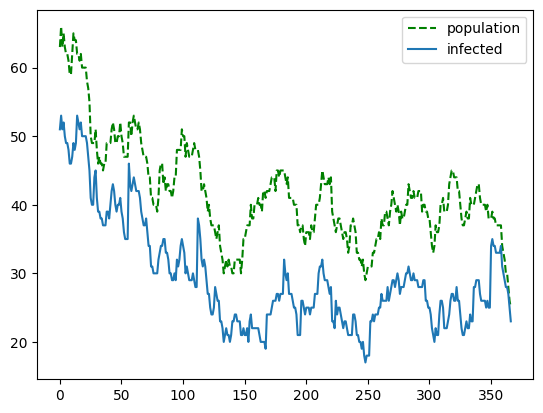

In [42]:
sns.lineplot(ftrace.sum(0), color="green", linestyle="--", label="population")
sns.lineplot(infections_cleaned.sum(0), label="infected")
plt.show()

<Axes: >

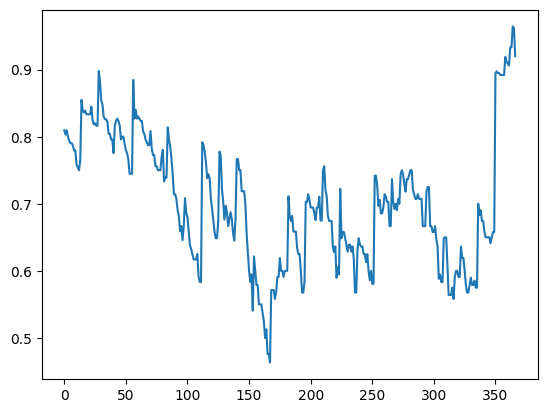

In [15]:
sns.lineplot(infections_cleaned.sum(0) / ftrace.sum(0))

In [ ]:
# smooth this out: what's the total population every two weeks?

In [16]:
ftrace

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### compress this down to weeks...

In [13]:
infections_cleaned.sum(0)

0      51.0
1      53.0
2      51.0
3      52.0
4      50.0
       ... 
362    28.0
363    28.0
364    27.0
365    25.0
366    23.0
Length: 367, dtype: float64

### Heterogeneous Observed Data

#### total count

In [54]:
total_count = infections_cleaned.sum(0).values

#### Floor-level infection rates

In [39]:
floor_counts = []
X = infections_cleaned.values
F = df_floor.values
for i in range(1,7):
    # does this work with matrix indexing?
    floor_count = np.nansum(X * (F == i), axis=0)
    floor_counts.append(floor_count)

#### Room-level infection rates

In [47]:
T = X.shape[1]
room_count = np.zeros(T)
room_count2 = np.zeros(T)
R = df_room.values
r = np.zeros(T).astype(int)
x = np.zeros(T)
w = np.zeros(T)
for t in range(T):
    rx, ry = np.meshgrid(r, r)
    rC = (rx == ry).astype(int)
    I = (x == 1).astype(int)
    infected_roommates = (rC * I).sum(1) # * w
    room_count[t] = (infected_roommates > 1).sum() / 2
    # update...
    # room_count2[t] = (np.unique(r[x == 1], return_counts=True)[1] > 1).sum()
    r = R[:, t]
    x = X[:, t]
    w = ftrace.values[:, t]

In [55]:
observed_data = np.stack([total_count] + floor_counts + [room_count])

In [57]:
observed_data

array([[51., 53., 51., ..., 27., 25., 23.],
       [ 3.,  4.,  2., ...,  6.,  5.,  5.],
       [14., 18., 17., ...,  2.,  2.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  5.,  6., ...,  2.,  1.,  1.],
       [ 0.,  4.,  4., ...,  4.,  3.,  3.]])

### Save

In [48]:
ftrace.head()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
infections_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_screen.head()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
observed_data

array([[51., 53., 51., ..., 27., 25., 23.],
       [ 3.,  4.,  2., ...,  6.,  5.,  5.],
       [14., 18., 17., ...,  2.,  2.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  5.,  6., ...,  2.,  1.,  1.],
       [ 0.,  4.,  4., ...,  4.,  3.,  3.]])

In [60]:
# write out data
output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed'
ftrace.to_csv(f"{output_dir}/facility_trace.csv")
# infections_cleaned.to_csv(f"{output_dir}/infections.csv")
with open(f"{output_dir}/observed_data.npy", "wb") as f:
    np.save(f, observed_data)
df_screen.to_csv(f"{output_dir}/screening.csv")
df_floor.to_csv(f"{output_dir}/floor_trace.csv")
df_room.to_csv(f"{output_dir}/room_trace.csv")